<a href="https://colab.research.google.com/github/jaehyun0220/DL/blob/master/2nd%20CDS%20Edu_Naver%20Clip%20Analysis%20with%20Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

네이버 댓글 분석을 통한 상위, 하위 클립 예측

### #1. 구글 인증

In [1]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### #2. 입력 데이터셋 확인

In [2]:
!ls ../gdrive/My\ Drive/output

file_ep10.csv	 file_ep16.csv	file_ep22.csv  file_ep4.csv
file_ep11.csv	 file_ep17.csv	file_ep23.csv  file_ep5.csv
file_ep12.csv	 file_ep18.csv	file_ep24.csv  file_ep6.csv
file_ep13.csv	 file_ep19.csv	file_ep25.csv  file_ep7.csv
file_ep14_1.csv  file_ep1.csv	file_ep26.csv  file_ep8.csv
file_ep14.csv	 file_ep20.csv	file_ep2.csv   file_ep9.csv
file_ep15.csv	 file_ep21.csv	file_ep3.csv   TheLastEmpress.csv


### #3. 필요 패키지 Install

In [3]:
!pip install konlpy # Okt, Kkma 등의 형태소 분석기 활용을 위한 설치
!pip install sacremoses sentencepiece # Bert 사용을 위한 Tokenizing을 위해 설치

     |████████████████████████████████| 19.4MB 1.6MB/s 
     |████████████████████████████████| 450kB 35.8MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 901kB 13.7MB/s 
     |████████████████████████████████| 1.2MB 29.2MB/s 


### #4.라이브러리 로드

In [4]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys
import regex as re
import random

from tqdm import tqdm_notebook, trange, tqdm_pandas
tqdm_pandas(tqdm_notebook())
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences


#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#데이터 분리를 위한 라이브러리 로드
from sklearn.model_selection import train_test_split

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot')
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### #5. 입력 데이터 Load 및 데이터 정제, 타겟 분리

In [5]:
# crawling을 통해 수집한 네이버 clip 회차별 댓글 List
filelist = os.listdir('../gdrive/My Drive/output')

# 총 26회차 491개 하이라이트 클립 존재 (전체 재생수 = 107,221,654 / 클립 당 평균 재생수 = 218,374), 
# 이 중에서 예고편, 미공개, 인터뷰 등 클립 제외하고 총 422회 클립 대상 crawling 진행
df_title = pd.read_csv('../gdrive/My Drive/output/TheLastEmpress.csv', encoding = 'euc-kr')
df_title.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

df_ep_tot = pd.DataFrame()

# 상위 하위 클립을 나누어 조회수 내림차순으로 rank를 매김 (1~4는 상위 클립, 5~8은 하위 클립)
for i in tqdm_notebook(filelist):
  if (i[:4] == 'file'):
    df_ep_temp = pd.read_csv('../gdrive/My Drive/output/'+i)
    df_ep_temp['play'] = df_ep_temp['play'].apply(lambda x: int(re.sub(',','', x[4:])))
    df_ep_temp['rank'] = df_ep_temp['play'].rank(method='dense', ascending=False)
    df_ep_tot = df_ep_tot.append(df_ep_temp)

# 크롤링 한 데이터에서 불필요한 열 삭제
df_ep_tot.drop(columns='Unnamed: 0', inplace=True)

# 상위 클립은 1로 하위 클립은 0으로 분류
df_ep_tot['target'] = np.where(df_ep_tot['rank']<=4,1,0)
df_ep_tot.tail()

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
1841,Major,와 ㅅㅂ...피지컬봐....,550,1,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1842,스폰지밥,"이쁘십니다 할때 나만설렜냐,,,,,,,",691,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1843,박한별,반했네,372,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1844,김민정,죄송하지만 이 분 이용합시다 ! 어쨌든 좋은게 좋은거죠 ..,593,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1845,블링블링,우빈이한테 전부 들이대는군,338,3,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0


### #6. 데이터 정제 - 댓글 중 분석 대상이 되는 contens 내 null data 삭제

In [6]:
df_ep_sample = df_ep_tot.copy()
df_ep_sample.dropna(how='any', inplace=True)
df_ep_sample.info()
df_ep_sample['target'].value_counts() # 3:1 imbalanced dataset (조회수가 많은 클립에 댓글이 많기 때문임))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40801 entries, 0 to 1845
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nick         40801 non-null  object 
 1   contents     40801 non-null  object 
 2   recomm       40801 non-null  int64  
 3   unrecomm     40801 non-null  int64  
 4   title        40801 non-null  object 
 5   play         40801 non-null  int64  
 6   like         40801 non-null  object 
 7   reple_count  40801 non-null  object 
 8   episode      40801 non-null  int64  
 9   rank         40801 non-null  float64
 10  target       40801 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


1    30632
0    10169
Name: target, dtype: int64

###7. 데이터 정제 - 정규식 & 형태소 분석

In [7]:
df_ep_sample['contents'] = df_ep_sample['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_ep_sample.dropna(how='any', inplace=True)

##8. 벡터 길이 산정을 위한 분포 체크

In [8]:
import konlpy
from konlpy.tag import Okt
from konlpy.utils import pprint

okt = Okt()

def morphs_okt(x):
  res = okt.morphs(x)
  if len(res) >= 1:
    res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
  else:
    res = ''
  res = 'NULL' if not res else res
  return res

In [9]:
df_ep_sample['contents'] = df_ep_sample['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_ep_sample['okt_token'] = df_ep_sample['contents'].apply(lambda x: morphs_okt(x))

df_ep_token = df_ep_sample.drop(df_ep_sample[df_ep_sample['okt_token'] == "NULL"].index)
df_ep_token.sample(5)

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target,okt_token
870,다룡,마지막장면에서 장나라 복수극으로 바뀌는 표정인데ㅋㅋㅋ 얼른 써니 흑화고고,41,1,"“괜찮으십니까 마마” 최진혁, 신성록에게 내쳐진 장나라 보호",319532,"1,438",223,5,3.0,1,"[마지막, 장면, 에서, 장나라, 복수, 극, 으로, 바뀌는, 표정, 인데, 얼른,..."
1302,희망맘,우리 성록님 귀요미 캐릭터한번가자구요 맨날 무섭구 화내는것만시켜서 힘들게하지말궁,17,0,"“뭐가 이리 맛있어?!” 신성록, 인생 첫 믹스 커피 맛에 ‘감동’",346000,"2,331",384,13,4.0,1,"[우리, 성, 록, 님, 귀요미, 캐릭터, 한번, 가자구요, 맨날, 무섭구, 화, ..."
1160,BMW,최진혁 코트자락에도 설렌다 ㅜㅜ,15,0,"‘타이밍의 귀재’ 김명수, 또다시 장나라·최진혁 극적 구출",145398,510,128,16,5.0,0,"[최진혁, 코트, 자락, 에도, 설렌다]"
1520,초딩,순옥킴이아니라 시간순삭킴,9,0,신은경 계락 간파하는 최진혁의 촉 ‘시한폭탄’,135145,632,101,15,7.0,0,"[순옥, 킴, 이, 아니라, 시간, 순삭, 킴]"
119,룰루,막장드라마 아역전문,10,0,"오아린, 진짜 엄마 윤소이 앞 분노 “어마마마 욕하지 마!”",594993,"2,976",394,13,1.0,1,"[막장드라마, 아역, 전문]"


## 공통 영역: Word Embedding을 위한 Hyper parameter Tuning

the no of covarage  95  percent word length is  32.0
32


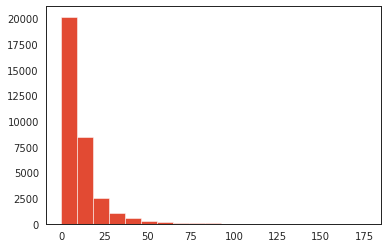

In [10]:
# token의 Histogram 분포를 바탕으로 대부분의 단어 길이 cover 가능한 단어 개수 찾기
# 신경망 학습을 위한 input 벡터 길이로 사용 - 적정 길이는 tokenizng 이후 분포를 보고 결정(코드 하단)
totalLenSent = [len(x) for x in df_ep_token['okt_token']] # 각 document의 단어 길이를 check
plt.hist(totalLenSent,bins = np.arange(0,max(totalLenSent),max(totalLenSent)/20))

coverage = 95
print("the no of covarage ", coverage, " percent word length is ", np.percentile(totalLenSent, coverage)) # 95%를 커버하는 수치는 41

# MAX_LEN = int(np.percentile(totalLenSent, coverage))
MAX_LEN = 32 # 벡터길이 32면 충분히 cover 가능하지만 Bert는 128 embedding을 사용 (교육 시연 속도를 위한 embedding size 축소)
print(MAX_LEN)

In [11]:
df_sample = pd.DataFrame()
df_sample['target'] = df_ep_token['target']
df_sample['contents'] = df_ep_token['okt_token'].apply(lambda x: ' '.join(x))
df_sample['target'].value_counts()

1    24882
0     8527
Name: target, dtype: int64

In [12]:
df_sample_final = df_sample.sample(frac=1).reset_index(drop=True).copy()
df_sample_final['target'].value_counts()

1    24882
0     8527
Name: target, dtype: int64

## BERT

###10. 데이터를 Bert 친화 형식으로 변경

In [13]:
# Bert 친화 형식으로 변경
all_df_bert = pd.DataFrame({
    'id':range(len(df_sample_final)), 
    'label':df_sample_final['target'], 
    'alpha':['a']*df_sample_final.shape[0], # 더미 컬럼이나 BERT Training을 위해 필요
    'text': df_sample_final['contents'].replace(r'\n', ' ', regex=True)
})
display(all_df_bert.head())

,id,label,alpha,text
0,0,1,a,최진혁 씨 눈빛 과 목소리 가 연기 에 더해지니 화면 장악 력 이 좋음
1,1,0,a,성 록 씨 안경 잘 어울림
2,2,1,a,황후 가 유모 한 데 달려가서 업어 치기 하 면 좋겠다
3,3,1,a,이혁 써니 가 교육 시켜서 둘 이 행복하게 해주세여
4,4,0,a,사랑 했기 때문 이겠지만 너무 멀리 가버리시는 듯 악다구니 지르는 모습 보기 좀 힘들었음


In [14]:
# 시간이 오래 걸리는 작업을 피하기 위해 임시 저장
all_df_bert.to_csv('../gdrive/My Drive/data/bert/all.tsv', sep='\t', index=False, header=False)
# Create sentence and label lists
df_all = pd.read_csv("../gdrive/My Drive/data/bert/all.tsv", delimiter='\t', header=None, names = ['id', 'label', 'alpha', 'text'])
print(df_all.shape)
df_all[df_all["id"]==0] # 정상 loading check

(33409, 4)


,id,label,alpha,text
0,0,1,a,최진혁 씨 눈빛 과 목소리 가 연기 에 더해지니 화면 장악 력 이 좋음


### #8. 데이터를 불러와 Tokenizing 준비

### #9. Pytorch 환경 내에서 BERT를 사용하기 위한 BERT 관련 Library Load

In [15]:
!pip install torch==1.4.0
!pip install transformers==3.5.1

     |████████████████████████████████| 753.4MB 23kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
     |████████████████████████████████| 1.3MB 14.7MB/s 
     |████████████████████████████████| 1.1MB 35.4MB/s 
     |████████████████████████████████| 2.9MB 37.4MB/s 
  Found existing installation: sentencepiece 0.1.95
    Uninstalling sentencepiece-0.1.95:
      Successfully uninstalled sentencepiece-0.1.95


In [16]:
import sacremoses
import sentencepiece

import pickle
import shutil
from joblib import Parallel, delayed

import torch
import torch.nn as nn # for neural net
import torch.utils.data
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

from IPython.core.interactiveshell import InteractiveShell # jupyter에서 마지막 값만 출력하는게 아니라 모든 출력값을 매번 연속적으로 출력
InteractiveShell.ast_node_interactivity = "all"           # all, last, last_expr, none (기본값은 'last_expr')

# from transformers import convert_tf_checkpoint_to_pytorch
from transformers import convert_bert_original_tf_checkpoint_to_pytorch

from transformers import BertTokenizer, AdamW, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification
from transformers.optimization import get_linear_schedule_with_warmup

from transformers import BertConfig # This is the Bert configuration file

### #11. Bert 학습을 위한 pretrained model을 pytorch 형태로 변환하여 work 경로로 복사

In [17]:
!mkdir ./bert_work/
PATH_PRETRAINED = "../gdrive/My Drive/data/bert/multi_cased_L-12_H-768_A-12/"
PATH_TORCH_PRETRAINED = "../gdrive/My Drive/data/bert/bert-base-multilingual-cased/"
PATH_HUGGING = "../gdrive/My Drive/data/bert/huggingface/"
PATH_WORK = './bert_work/'
sys.path.append(PATH_PRETRAINED)
sys.path.append(PATH_WORK)

BERT_MODEL_CONFIG = PATH_WORK+'config.json'

shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-config.json', PATH_WORK + 'config.json')
shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-pytorch_model.bin', PATH_WORK + 'pytorch_model.bin')
shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-vocab.txt', PATH_WORK + 'vocab.txt')

'./bert_work/config.json'

'./bert_work/pytorch_model.bin'

'./bert_work/vocab.txt'

### BERT 사용 관련 Hyperparameter Setting

In [18]:
seed = 888
MAX_SEQ_LEN = MAX_LEN # token분포 바탕으로 32 선정 (대부분의 단어 길이 cover)

NUM_LABELS = len(df_sample_final['target'].unique()) #2 If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy)
training_epochs = 10
lr = 2e-5
batch_size = 128

FILE_VOCAB = PATH_WORK+'vocab.txt'

bert_model = 'bert-base-multilingual-cased'
do_lower_case = 'uncased' in bert_model
device = torch.device('cuda') # GPU 사용 setting

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### 데이터를 불러와 Tokenizing 준비

In [19]:
sentences = df_all.text.values
# add special tokens for BERT
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df_all.label.values
len(sentences)

33409

### #13. Bert 형식으로 Tokenizing 시행
#### - 여기서는 직접 map을 이용해 직접 vocab을 다운로드

In [20]:
# OKT로 Tokenize 한 데이터를 string으로 붙인 뒤 이를 다시 bert 형태로 tokenizing
%%time
tokenizer = BertTokenizer.from_pretrained(FILE_VOCAB, cache_dir=None, do_lower_case=do_lower_case)

for i in range(0, len(sentences), 2000):
  sentence = sentences[i:(i+2000)] 
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentence]
  
  # 4000번에 한개씩 결과 출력 
  if (i % 4000) == 0:
    print(tokenized_texts)
    
  input_ids_tmp = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  if i < 2:
    print(input_ids_tmp)

  input_ids_tmp = pad_sequences(input_ids_tmp, maxlen=MAX_LEN, dtype="long", truncating='post', padding='post')
  if i==0:
    input_ids = input_ids_tmp
    print(i)
  else:
    input_ids = np.vstack((input_ids, input_ids_tmp))
    print(i, '완료', input_ids.shape, input_ids_tmp.shape)

Model name './bert_work/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, TurkuNLP/bert-base-finnish-cased-v1, TurkuNLP/bert-base-finnish-uncased-v1, wietsedv/bert-base-dutch-cased). Assuming './bert_work/vocab.txt' is a path, a model identifier, or url to a directory containing tokenizer files.
Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
loading file ./bert_work/vocab.txt


[['[CLS]', '최', '##진', '##혁', '씨', '눈', '##빛', '과', '목', '##소', '##리', '가', '연', '##기', '에', '더', '##해', '##지', '##니', '화', '##면', '장', '##악', '력', '이', '좋', '##음', '[SEP]'], ['[CLS]', '성', '록', '씨', '안', '##경', '잘', '어', '##울', '##림', '[SEP]'], ['[CLS]', '황', '##후', '가', '유', '##모', '한', '데', '달', '##려', '##가', '##서', '업', '##어', '치', '##기', '하', '면', '좋', '##겠', '##다', '[SEP]'], ['[CLS]', '이', '##혁', '써', '##니', '가', '교', '##육', '시', '##켜', '##서', '둘', '이', '행', '##복', '##하게', '해', '##주', '##세', '##여', '[SEP]'], ['[CLS]', '사', '##랑', '했', '##기', '때', '##문', '이', '##겠', '##지만', '너', '##무', '멀', '##리', '가', '##버', '##리', '##시', '##는', '듯', '악', '##다', '##구', '##니', '지', '##르는', '모', '##습', '보', '##기', '좀', '힘', '##들', '##었', '##음', '[SEP]'], ['[CLS]', '엄', '##마', '맞', '##냐', '애', '한', '##테', '작', '##품', '이라', '##니', '[SEP]'], ['[CLS]', '완', '##전', '막', '##장', '##드라마', '그', '##런', '##데', '보', '##게', '됨', '[SEP]'], ['[CLS]', '과', '##거', '만', '아', '##니', '##면', '진', '##짜', '아', '##아', '귀'

In [21]:
np.save('wordpiece_tokenize_32.npy', input_ids)
input_ids = np.load('wordpiece_tokenize_32.npy')
print(input_ids.shape)
input_ids[:1]

(33409, 32)


array([[   101,   9764,  18623, 119432,   9516,   9034, 119007,   8898,
          9284,  22333,  12692,   8843,   9568,  12310,   9559,   9074,
         14523,  12508,  25503,   9993,  14867,   9657, 119110,   9193,
          9638,   9685,  32158,    102,      0,      0,      0,      0]])

## 분류에 사용할 클래스 Load

In [22]:
X = input_ids
Y = labels

# Train & Test Set 분리
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [23]:
# 잘 나누어졌는지 확인
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(26727, 32) (6682, 32) (26727,) (6682,)


In [24]:
# Dataset을 상속한 TensorDataset은 train data x와 레이블 y를 묶어놓은 컨테이너로 tensor만 전달 가능함
# X는 torch.long 형태의 텐서로, y는 torch.float 타입의 텐서로 입력하여 
# pytorch에서 연산할 수 있는 기본 구조로 변경하여 train_dataset으로 할당
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_x,dtype=torch.long), torch.tensor(train_y,dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_x,dtype=torch.long), torch.tensor(test_y,dtype=torch.long))

print(train_x.shape)
print(train_y.shape)

(26727, 32)
(26727,)


In [25]:
train_losses = []

# Train 함수
def bert_train_net(net, train_loader, optimizer, device="cuda"):
  tq = tqdm_notebook(range(training_epochs))

  for epoch in tq:
    tr_loss = 0.
    nb_tr_examples, nb_tr_steps = 0,0

    # 신경망을 훈련 모드로 설정
    net.train()
    tk0 = tqdm_notebook(enumerate(train_loader),total=len(train_loader),leave=False)
    
    # iteration 1회에 train_loader의 batch_size (여기서는 64)만큼씩 읽어와 한꺼번에 batch처리 batch_size * i (여기서는 i = ) 가 전체 train data set의 크기가 될때까지 loop
    for i,(x, y) in tk0:
      x=x.to(device) # len(x)는 batch_size
      y=y.to(device)

      loss, logit = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=y)  # forward

      optimizer.zero_grad() # step과 zero_grad는 쌍을 이루는 것이라고 생각하면 됨 # optimizer의 gradient를 0으로 초기화
      
      train_losses.append(loss.item())

      loss.backward() # backpropagation
      optimizer.step() # update gradients

      # update tracking variables
      tr_loss += loss.item()
      nb_tr_examples += x.size(0)
      nb_tr_steps += 1
      # running_loss += loss.item() # loss calculate

      train_losses.append(tr_loss/nb_tr_steps)

    print("epoch: {}/{} | train_loss: {:.4f} ".format(epoch, training_epochs, tr_loss/nb_tr_steps))
    # train_losses.append(running_loss/len(train_loader))
    # torch.save(model.state_dict(), output_model_file)

In [26]:
# BertForSequenceClassification is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. 
# As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

# Load pre-trained model (weights)

CACHE_DIR = 'cache/'

bert_config = BertConfig.from_json_file(BERT_MODEL_CONFIG)
bert_config.num_labels = NUM_LABELS

print("bert_config is ", bert_config)

model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=NUM_LABELS)
param_optimizer = list(model.named_parameters())

for p in model.bert.embeddings.parameters():
    p.requires_grad = False

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

### In Transformers, optimizer and schedules are splitted and instantiated like this:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

bert_config is  BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 119547
}



https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp2pux44uj


storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json in cache at /root/.cache/torch/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
creating metadata file for /root/.cache/torch/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/torch/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range

https://huggingface.co/bert-base-multilingual-cased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpg8yockqc


storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/torch/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
creating metadata file for /root/.cache/torch/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
loading weights file https://huggingface.co/bert-base-multilingual-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/torch/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
model.to(device) # GPU 연산을 위해 cuda로 전송

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
bert_train_net(model, train_loader, optimizer, device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

epoch: 0/10 | train_loss: 0.5602 


epoch: 1/10 | train_loss: 0.5087 


epoch: 2/10 | train_loss: 0.4587 


In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_losses)
plt.show()

In [ ]:
preds = []
labels = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(y_preds, real_ys, prt_cnt):
    pred_flat = np.argmax(y_preds, axis=1).flatten()
    labels_flat = real_ys.flatten()
    
    # 10번에 한개씩 결과 출력 
    if (prt_cnt % 10) == 0:
        print("pred_flat is ", pred_flat)
        print("labels_flat is ", labels_flat)
    preds.append(pred_flat)
    labels.append(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 평가 헬퍼 함수
def bert_eval_net(net, data_loader, device="cuda"):
  # Dropout 및 BatchNorm 무효화
  net.eval()

  eval_acc = 0
  nb_eval_examples, nb_eval_steps = 0,0
  prt_cnt = 1

  for x, y in data_loader:
    x=x.to(device)
    y=y.to(device)
    with torch.no_grad():
      y_preds = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=None)  # forward

    #Move logits and labels to CPU
    y_preds = y_preds[0].detach().cpu().numpy()
    real_ys = y.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(y_preds, real_ys, prt_cnt)
    print("tmp_eval_accuracy : ", tmp_eval_accuracy)

    eval_acc += tmp_eval_accuracy
    nb_eval_steps += 1
    prt_cnt += 1

  print("Validation Accuracy: {}".format(eval_acc/nb_eval_steps))

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
bert_eval_net(model, test_loader, device)

In [ ]:
def result_summary(pred_y, real_y):
  print("Accuracy: {:.4f}".format(accuracy_score(real_y, pred_y)))
  print("Confusion Matrix: \n", confusion_matrix(real_y, pred_y))
  print("Classification Report Matrix: \n", classification_report(real_y, pred_y, digits=3))

  roc_auc = roc_auc_score(real_y, pred_y)
  print("roc_auc score is : {:.4f}".format(roc_auc))

  fpr, tpr, threshold = roc_curve(real_y, pred_y)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### 최종 List를 하나의 List로 펴줌

In [ ]:
import itertools
preds_flat = list(itertools.chain(*preds))
labels_flat = list(itertools.chain(*labels))

result_summary(preds_flat, labels_flat)